# This notebook references data from 3 sources:
- CMEMS hist048: https://data.marine.copernicus.eu/product/INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/description
- The NAFC55 deployment spreadsheet
- The NAFC55 NetCDF data files from archive

### Begin by scrolling down until you reach the "NAFC55 dataset" section!

In [150]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import collections
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from shapely.geometry import Point, Polygon
import xarray as xr
from IPython.display import HTML
%matplotlib inline
import cmd
import shutil
cli = cmd.Cmd()

drifter_dir = "C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/"
nafc55_dir = os.path.join(drifter_dir, "nafc", "nafc55_netcdf")
hist048_dir = os.path.join(drifter_dir, "CMEMS", "updated_20231025", "hist048", "hist048_netcdf")

In [151]:
LatLonBoundingBox = collections.namedtuple('LatLonBoundingBox', ('minlon', 'maxlon', 'minlat', 'maxlat'))
shelf_coords = LatLonBoundingBox(minlon=-90, maxlon=-30, minlat=35, maxlat=80)


def determine_shelf_edges(shelf_coords):
    shelf_edges = [(shelf_coords.maxlon, shelf_coords.maxlat),
                   (shelf_coords.maxlon, shelf_coords.minlat),
                   (shelf_coords.minlon, shelf_coords.minlat),
                   (shelf_coords.minlon, shelf_coords.maxlat),
                   (shelf_coords.maxlon, shelf_coords.maxlat)]
    return shelf_edges


def wrap_to_180(x):
    """Wrap values in degrees into the interval [-180, 180]."""
    if isinstance(x, np.ndarray):
        with np.errstate(invalid='ignore'):
            x_wrap = np.remainder(x, 360)
        x_wrap[x_wrap > 180] -= 360
        return x_wrap
    elif hasattr(x, "__len__"):
        return wrap_to_180(np.array(x))
    else:
        return wrap_to_180(np.array([x]))[0]  


def plot_tracks(df, tstr, shelf_coords, test_region=False, savedir=None):
       
    plt.figure(figsize=(20, 20))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
    
    shelf_edges = determine_shelf_edges(shelf_coords)
    slons = list(zip(*shelf_edges))[0]
    slats = list(zip(*shelf_edges))[1]
    ax.plot(slons, slats, 'r-')
    
    for uniq in np.unique(df.filenames.values):
        trackdf = df.loc[df.filenames.values == uniq]
        trackdf_in = trackdf.loc[trackdf.pip.values]
        leglab = '_no_label_'
        if tstr == 'nafc55_tracks_not_in_hist048':
            leglab = uniq
        if not test_region:
            ax.plot(wrap_to_180(trackdf.lons.values), trackdf.lats.values, 'w-', markersize=1)
        ax.plot(wrap_to_180(trackdf_in.lons.values), trackdf_in.lats.values, '-', markersize=1, label=leglab)
        
    set_type = "Full data set domain"
    titlestr = (tstr + "\n" + set_type)
    if test_region:
        set_type = "Cropped to test region"
        titlestr = (tstr + "\n" + set_type)
        bounds = [shelf_coords.minlon - 2, shelf_coords.maxlon + 2,
                  shelf_coords.minlat - 2, shelf_coords.maxlat + 2]
        ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.1, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    gl.xlines = False
    plt.title(titlestr)
    if tstr == 'nafc55_tracks_not_in_hist048':
        ax.legend(fontsize=12)
    if savedir is not None and os.path.isdir(savedir):
        figname = tstr + "_" + set_type.replace(" ", "_")
        #print('\n\nSaving ' + os.path.join(savedir, figname + '_20231030.png'))
        plt.savefig(os.path.join(savedir, figname + ".png"))

    plt.show()
    
    
def point_in_polygon(pt, poly):
    point = Point(pt)
    bool_within = point.within(poly) 
    #bool_contains = poly.contains(point)
    return(bool_within)


def grab_coords(ds, tstr=None):
    if tstr == "GDP":
        lons = wrap_to_180(ds.longitude.values)
        lats = ds.latitude.values
        time = ds.time.values
    else:
        lons = wrap_to_180(ds.LONGITUDE.values)
        lats = ds.LATITUDE.values
        time = ds.TIME.values
    return lons, lats, time


def create_pickle_file(picklefile, data):
    with open(picklefile,'wb') as f:
        pickle.dump(data, f)


def load_pickle_file(picklefile):
    with open(picklefile,'rb') as f:
        data = pickle.load(f)
    return data

        
def read_netcdf_file(fname):
    try:
        with xr.load_dataset(fname) as ds:
            return(ds)
    except:
        print('bad data: ', fname)
        return None
        

def load_drifter_dataset_dict(datafiles):
    dsdict = {}
    for file in glob.glob(os.path.join(datafiles, "*.nc")):
        if read_netcdf_file(file) is not None:
            ds = read_netcdf_file(file)
            dsdict[os.path.basename(file)] = ds
    return dsdict


def load_drifter_datasets(datafiles, picklefile, use_pickle=True): 
    
    def load_from_pickle(picklefile):
        #print('attempting to load data from pickled file')
        ds_dict = load_pickle_file(picklefile)
        return ds_dict
        
    def load_from_files(datafiles, picklefile):
        print('loading datasets from files and creating pickled list of datasets\n')
        ds_dict = load_drifter_dataset_dict(datafiles)
        create_pickle_file(picklefile, ds_dict)
        return ds_dict
    
    if use_pickle:
        try: 
            ds_dict = load_from_pickle(picklefile)
        except:
            ds_dict = load_from_files(datafiles, picklefile)
    else:
        ds_dict = load_from_files(datafiles, picklefile)
        
    return ds_dict


def summary_str(smval, bigval):
    perc = "{:.1f}".format((smval / bigval) * 100)
    percstr = (str(smval) + ' of ' + str(bigval) + ' points are in the region (' + str(perc) + '%)')
    return percstr
    
    
def exclude_by_outside_extremes(df, shelf_coords):
    df.loc[(df['lons'] < (shelf_coords.minlon)), 'pip'] = False 
    df.loc[(df['lons'] > (shelf_coords.maxlon)), 'pip'] = False
    df.loc[(df['lats'] < (shelf_coords.minlat)), 'pip'] = False
    df.loc[(df['lats'] > (shelf_coords.maxlat)), 'pip'] = False
    percstr = summary_str(len(df['pip'][df['pip'].values].values), 
                          len(df['pip'].values))
    return percstr, df
    
    
def exclude_by_outside_polygon(df, shelf_coords):
    shelf_edges = determine_shelf_edges(shelf_coords)
    df['temp'] = [point_in_polygon(point, Polygon(shelf_edges[0:4])) 
                  for point in zip(masterdf.lons.values, masterdf.lats.values)]
    df.loc[df['temp'] == False, 'pip'] = False    
    percstr = summary_str(len(df['pip'][df['pip'].values]), 
                          len(df['pip']))
    return percstr, df


def toss_outside(df, shelf_coords, exclude_type='fast'):
    if exclude_type == 'fast':
        percstr, df = exclude_by_outside_extremes(df, shelf_coords)
        print(percstr + ' after removing any points smaller or larger than test region extremes')
    
    if exclude_type == 'slow':
        percstr, df = exclude_by_outside_extremes(df, shelf_coords)
        print('\n', percstr + ' after removing any points smaller or larger than test region extremes')
        percstr, df = exclude_by_outside_polygon(df, shelf_coords)
        print(percstr + ' after also removing any points outside the test region polygon ' 
              + '(useful for irregularly shaped test regions)')
        
    return df
    
    
def create_master_df(ds_dict, tstr): 
    track_names = list(ds_dict.keys())
    #print('\nIncluding ' + str(len(track_names)) + ' drifter tracks\n')
    all_lons = []
    all_lats = []
    all_times = []
    all_idents = []
    for filename, ds in ds_dict.items():
        lons, lats, times = grab_coords(ds, tstr)
        all_lons.extend(lons)
        all_lats.extend(lats)
        all_times.extend(times)
        all_idents.extend([filename] * len(lons))

    masterdf = pd.DataFrame({
        'lons': all_lons,
        'lats': all_lats,
        'times': all_times,
        'filenames': all_idents,
        'pip': [True] * len(all_lons)
    })
    return masterdf


def determine_points_per_year(df):
    # to count within bins, use value_counts(bins=num_of_bins)
    ppy = pd.to_datetime(df['times']).dt.year.value_counts(normalize=False)  
    ppy_rel = pd.to_datetime(df['times']).dt.year.value_counts(normalize=True)
    countdf = pd.DataFrame()
    countdf['year'] = ppy.index.tolist()
    countdf['pts_inside'] = ppy.tolist()
    countdf['rel_freq'] = ["{:.2f}".format(relfreq) for relfreq in ppy_rel.tolist()]
    display(HTML(countdf.to_html(index=False)))
    return ppy


# summarize the tracks/points inside the selected test region:
def summarize_point_and_track_counts(masterdf, indf, tstr):
    num_tracks_global = len(np.unique(masterdf.filenames.values))
    num_tracks_region = len(np.unique(indf.filenames.values))
    num_points_global = len(masterdf.lons.values)
    num_points_region = len(indf.lons.values)
    times_global_min = min(pd.to_datetime(masterdf['times'])).strftime('%Y-%m-%d')
    times_global_max = max(pd.to_datetime(masterdf['times'])).strftime('%Y-%m-%d')
    times_region_min = min(pd.to_datetime(indf['times'])).strftime('%Y-%m-%d')
    times_region_max = max(pd.to_datetime(indf['times'])).strftime('%Y-%m-%d')
    print('\nSummary\n---------\n')
    #if tstr == 'hist048':
    #    print('The following results only consider the index file, so some ' 
    #          + 'points in each track may still be outside the test area\n\n')
    print('There were ' + str(num_tracks_global) + ' tracks (including ' + str(num_points_global) + ' total points) '
          + 'originally covering times from ' + times_global_min + ' to ' + times_global_max 
          + '.\n' + str(num_tracks_region) + ' tracks (including ' + str(num_points_region) 
          + ' points) are in both the right timeframe and cross the NL and LAB shelves.\n'
          + 'The time range in the reduced dataset is ' +  times_region_min + ' to ' + times_region_max + '\n')
        

def plot_yearly_hist(df, tstr, savedir=None):
    #df = df.sort_values(ascending=False)
    num_bars = len(np.unique(df.values))
    plt.figure(facecolor='white', figsize=(10, 6))
    ax = df.value_counts()[:num_bars].plot(kind='barh')
    plt.title(tstr, fontsize=14)
    plt.ylabel('Year', fontsize=12)
    plt.xlabel('Number of points inside test domain', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if savedir is not None and os.path.isdir(savedir):
        figname = tstr + "_hist" 
        print('\n\nSaving ' + os.path.join(savedir, figname + '.png'))
        plt.savefig(os.path.join(savedir, figname + ".png"))
    plt.show()


def display_nice_list(mylist):
    cli.columnize(mylist, displaywidth=shutil.get_terminal_size().columns)
    

def show_summary(drifter_dir, datafiles, tstr, 
                 shelf_coords, exclude_type='fast', 
                 zoom_plot=False, use_masterdf_pickle=True, 
                 summarize_excluded=False):

    # load the dictionary of datasets from a pickled file if it exists, otherwise load from data
    # files and created a pickled file to use next time. Then, create a dataframe with all the
    # values from all the tracks.
    picklefile = os.path.join(drifter_dir, (tstr + '_filelist.pkl'))
    ds_dict = load_drifter_datasets(datafiles, picklefile, use_pickle=True)
    masterdf = create_master_df(ds_dict, tstr)

    # Use toss_outside to set masterdf['pip'] to False for any points outside the test domain. If
    # a pickle file exists, load from there to save time. Otherwise pickle the data for next time.
    masterdf_picklefile = os.path.join(drifter_dir, tstr + "_masterdf.pkl")
    if use_masterdf_pickle:
        try:
            masterdf = load_pickle_file(masterdf_picklefile)
        except:
            masterdf = toss_outside(masterdf, shelf_coords, exclude_type=exclude_type)
            create_pickle_file(masterdf_picklefile, masterdf)
    else:
        masterdf = toss_outside(masterdf, shelf_coords, exclude_type=exclude_type)
        create_pickle_file(masterdf_picklefile, masterdf)
    
    #--------------------------------------------------------------------------------------------
    # Summarize/plot either all tracks for either hist048 or NAFC55 full data set (default). 
    # Otherwise, summarize/plot the NAFC55 tracks that do NOT appear in the hist048 dataset:
    #--------------------------------------------------------------------------------------------
    if summarize_excluded:
        #---------------------------------------------------------------------------------------------
        # (optional) plot/summarize just the nafc55 tracks that do not show up in the hist048 dataset:
        #---------------------------------------------------------------------------------------------
        # Telecom IDs listed in the deployment spreadsheet that do not show up in the hist048 dataset
        excluded_tracks = list(
            map(str, [300234062853860, 300234062458690, 300234062551640, 300234063512980, 300234063515680,
                      300234063511220, 300234063617000, 300234063516680, 300234063129520, 300234063122550, 
                      300234063122470, 300234063125370, 300234063123370, 300234063121480, 300234063124480, 
                      300234063123360, 300234063122480, 300234063515630, 300234063518580, 300234063517970, 
                      300234063514970, 300234063120370, 300234063614000, 300234063266860, 300234063262840, 
                      300234063267840, 300234063264840, 300234063263840, 300234065806830]))
        
        masterdf['Telecom_ID'] = [x.split('D')[0].replace('nafc', '') for x in masterdf['filenames']]
        
        # tossing any NAFC55 tracks that are included in hist048 (only looking at NAFC55 tracks that do not
        # appear in hist048 from now on):
        excluded_df = masterdf
        excluded_df = excluded_df.loc[excluded_df['Telecom_ID'].isin(excluded_tracks)]
        
        # print a list of the excluded Teleids
        teleids_from_files = [str(x) for x in np.unique(excluded_df['Telecom_ID'].values.tolist())]
        print('\n\nplotting data from ' + str(len(teleids_from_files)) + ' tracks that are not in hist048:\n')
        display_nice_list(teleids_from_files)
        print('\n\nThe other 11 Telecom IDs that are in the spreadsheet but not in hist048 or our NetCDF data set:\n') 
        master_id_list = [str(x) for x in np.unique(masterdf['Telecom_ID'].values.tolist())]
        other = [x for x in excluded_tracks if x not in teleids_from_files]
        display_nice_list(other)
        print('\n\n')
        
        # only plot points that are inside the test area
        excluded_df = excluded_df.loc[excluded_df['pip'].values]
        # display a summary of the number of points/tracks per year in the total  
        # data set as well as just the data within the test area.
        #summarize_point_and_track_counts(masterdf, excluded_df, tstr)
        ppy = determine_points_per_year(excluded_df)
        # plot the number of points per year
        yearly_df_excluded = pd.to_datetime(excluded_df['times']).dt.year
        plot_yearly_hist(yearly_df_excluded, tstr, savedir=os.path.join(drifter_dir, "plots", "plots_excluded"))
        # make a quick plot of the tracks
        plot_tracks(excluded_df, tstr, shelf_coords, test_region=zoom_plot, 
                    savedir=os.path.join(drifter_dir, "plots", "plots_excluded"))
    
    else:
        #---------------------------------------------------------------------------------------------
        # (default) look at the entire dataset
        #---------------------------------------------------------------------------------------------
        # using only the rows where pip is True:
        indf = masterdf.loc[masterdf['pip'].values]
        # display a summary of the number of points/tracks per year in the total 
        # data set as well as just the data within the test area.
        summarize_point_and_track_counts(masterdf, indf, tstr)
        ppy = determine_points_per_year(indf)
        # plot the number of points per year
        yearly_df = pd.to_datetime(indf['times']).dt.year
        plot_yearly_hist(yearly_df, tstr, savedir=os.path.join(drifter_dir, "plots"))
        # make a quick plot
        plot_tracks(masterdf, tstr, shelf_coords, test_region=zoom_plot, 
                    savedir=os.path.join(drifter_dir, "plots"))

# NAFC55 dataset


Summary
---------

There were 55 tracks (including 793835 total points) originally covering times from 2015-07-29 to 2019-08-29.
55 tracks (including 457917 points) are in both the right timeframe and cross the NL and LAB shelves.
The time range in the reduced dataset is 2015-07-29 to 2019-08-29





Saving C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/plots\nafc55_hist.png


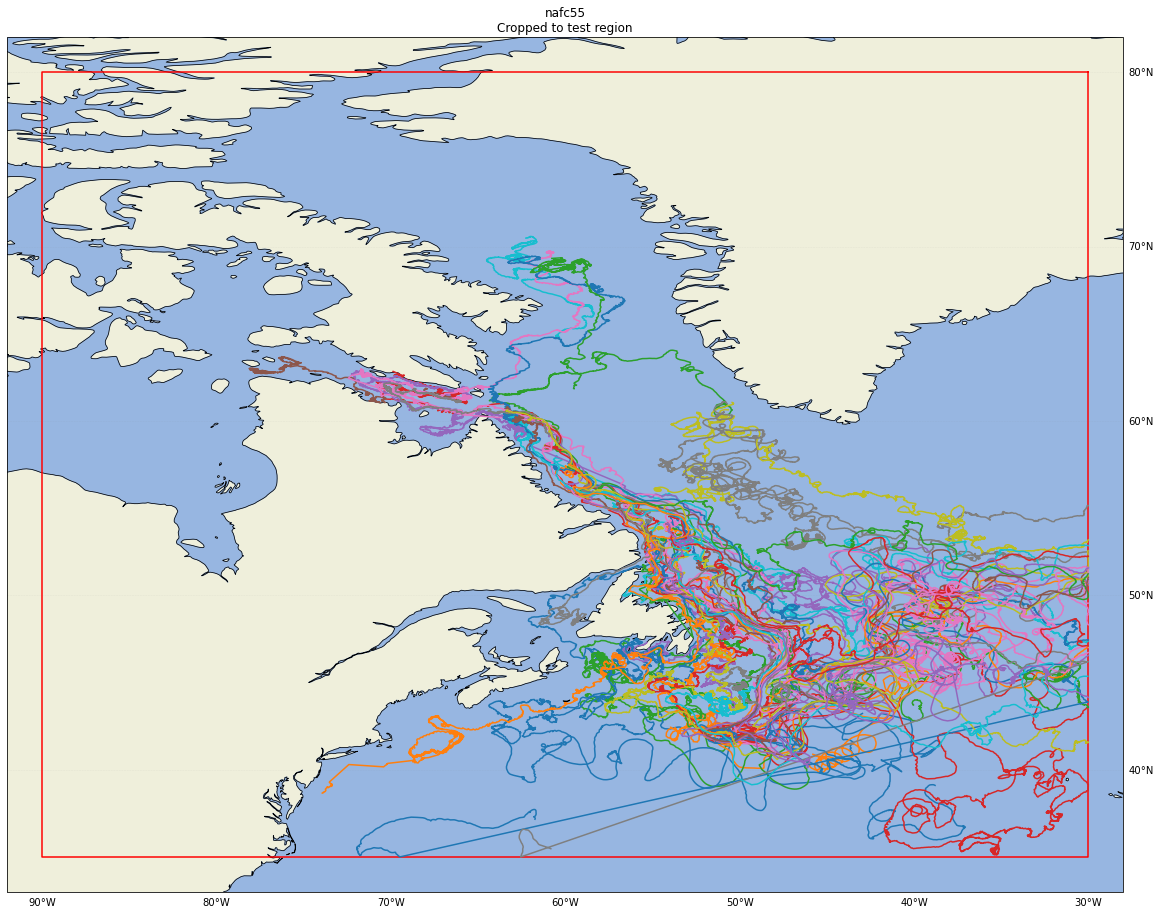

In [152]:
show_summary(drifter_dir, nafc55_dir, 'nafc55', shelf_coords, exclude_type='fast', zoom_plot=True)

# NAFC55 drifter tracks that are NOT in hist048

See Compare_CMEMS_hist048_and_NAFC55_TelecomIDs.ipynb for more information on which tracks are in each set.



plotting data from 18 tracks that are not in hist048:

300234062458690  300234063120370  300234063123370  300234063514970  300234063516680  300234063614000
300234062551640  300234063122470  300234063267840  300234063515630  300234063517970  300234063617000
300234062853860  300234063123360  300234063512980  300234063515680  300234063518580  300234065806830


The other 11 Telecom IDs that are in the spreadsheet but not in hist048 or our NetCDF data set:

300234063511220  300234063122550  300234063121480  300234063122480  300234063262840  300234063263840
300234063129520  300234063125370  300234063124480  300234063266860  300234063264840







Saving C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/plots\plots_excluded\nafc55_tracks_not_in_hist048_hist.png


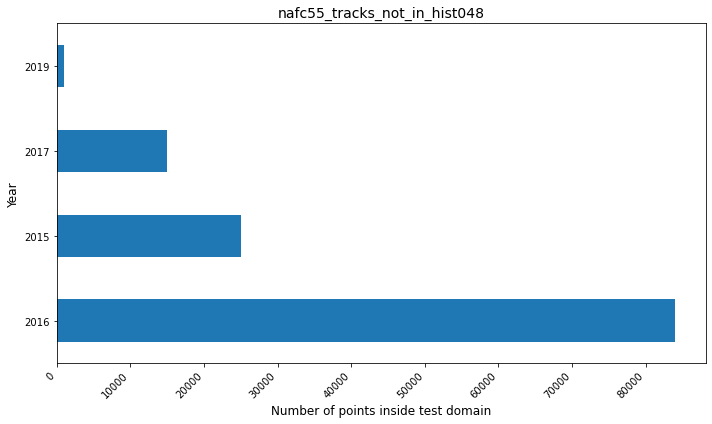

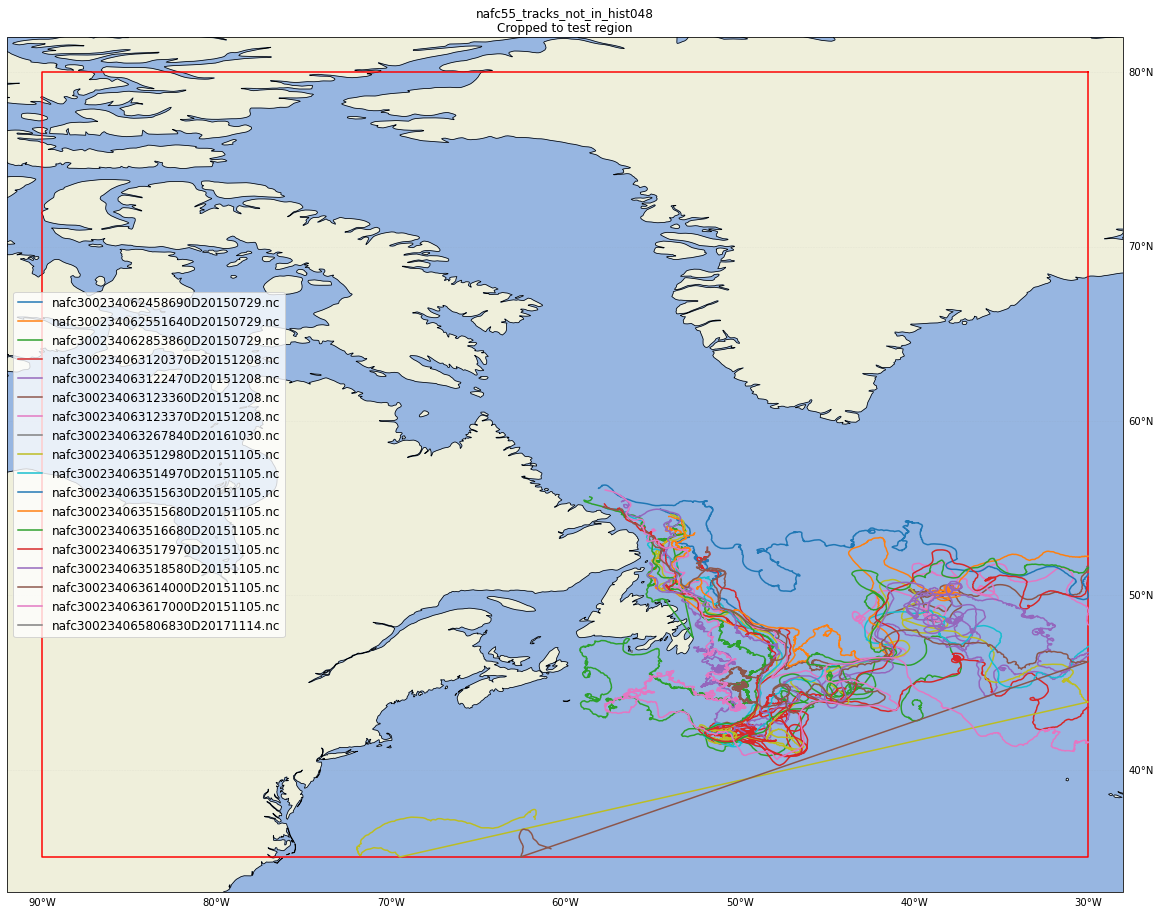

In [153]:
show_summary(drifter_dir, nafc55_dir, 'nafc55_tracks_not_in_hist048', shelf_coords, 
             exclude_type='fast', zoom_plot=True, summarize_excluded=True)

# CMEMS hist048 dataset


Summary
---------

The following results only consider the index file, so some points in each track may still be outside the test area


There were 2106 tracks (including 17393055 total points) originally covering times from 2002-01-01 to 2023-09-30.
1513 tracks (including 4891397 points) are in both the right timeframe and cross the NL and LAB shelves.
The time range in the reduced dataset is 2002-01-01 to 2023-09-30





Saving C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/plots\hist048_hist.png


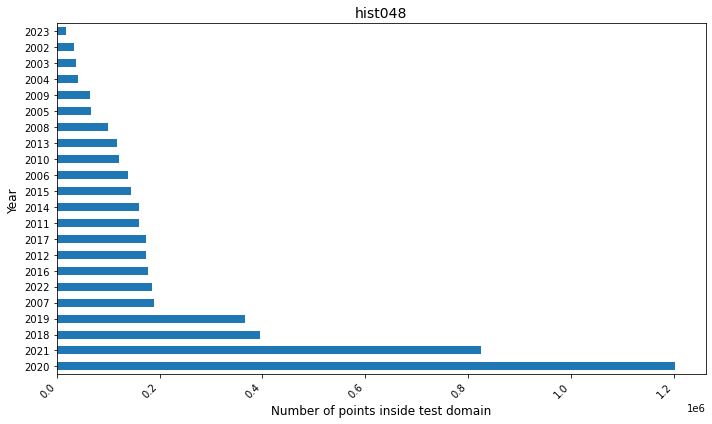



Saving C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/plots\hist048_Cropped_to_test_region_20231030.png


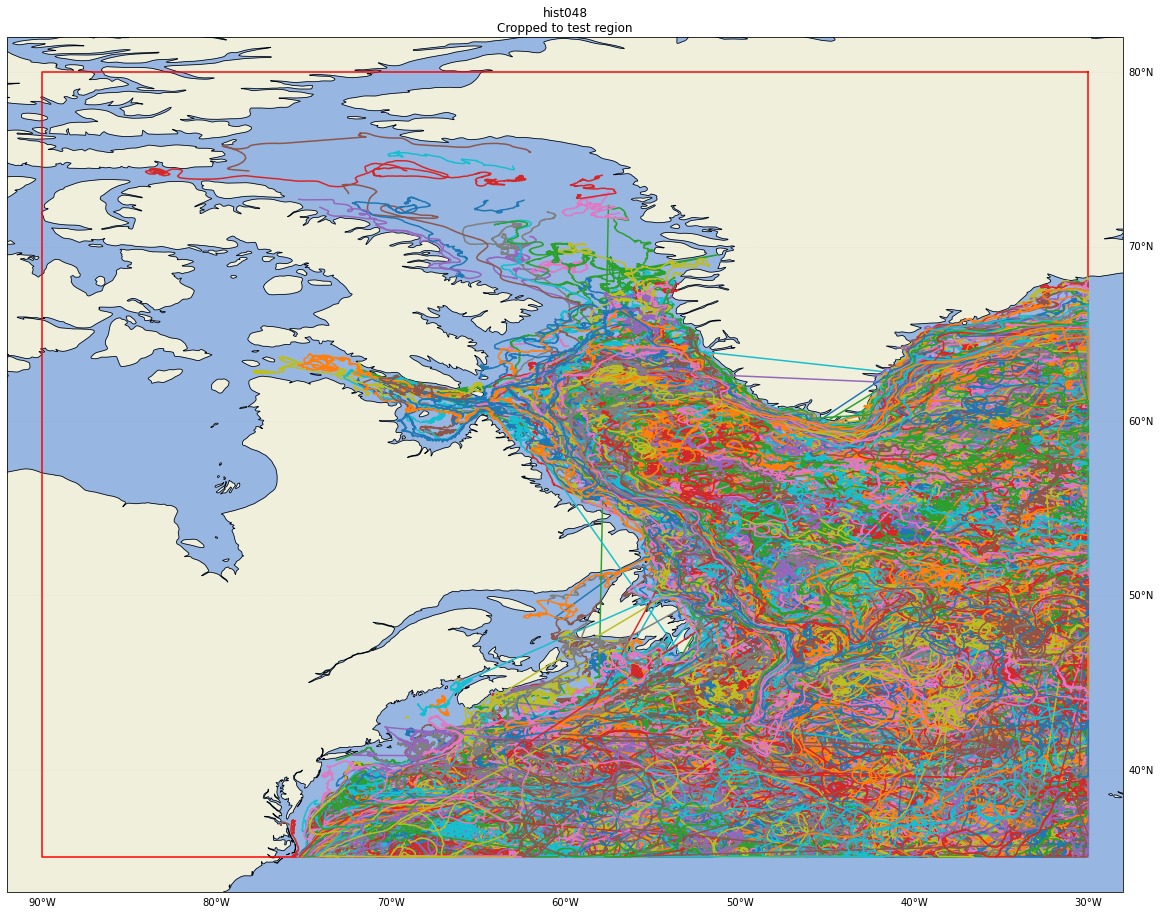

In [4]:
show_summary(drifter_dir, hist048_dir, 'hist048', shelf_coords, exclude_type='fast', zoom_plot=True)